# Example of using the IDR web API

OMERO.web uses a default session backend authentication
scheme to authenticate.
First create a HTTP session using the
[`requests`](http://docs.python-requests.org/en/master/) library:

In [1]:
from IPython.display import display, HTML
import requests
# initial data
IDR_BASE_URL = "https://idr.openmicroscopy.org"


In [2]:
INDEX_PAGE = "%s/webclient/?experimenter=-1" % IDR_BASE_URL
# create http session
with requests.Session() as session:
    request = requests.Request('GET', INDEX_PAGE)
    prepped = session.prepare_request(request)
    response = session.send(prepped)
    if response.status_code != 200:
        response.raise_for_status()

# Studies:

## Get Study map annotation:

In [3]:
MAP_URL = "{base}/webclient/api/annotations/?type=map&{type}={screen_id}"

SCREEN_ID = 102

qs = {'base': IDR_BASE_URL, 'type': 'screen', 'screen_id': SCREEN_ID}
url = MAP_URL.format(**qs)
for a in session.get(url).json()['annotations']:
    namespace = a['ns']
    for v in a['values']:
        key = v[0]
        value = v[1]
        print(key, value)

(u'Study Type', u'high content screen')
(u'Organism', u'Homo sapiens')
(u'Screen Type', u'primary screen')
(u'Screen Technology Type', u'RNAi screen')
(u'Imaging Method', u'fluorescence microscopy')
(u'Publication Title', u'Integration of biological data by kernels on graph nodes allows prediction of new genes involved in mitotic chromosome condensation.')
(u'Publication Authors', u'Heriche JK, Lees JG, Morilla I, Walter T, Petrova B, Roberti MJ, Hossain MJ, Adler P, Fernandez JM, Krallinger M, Haering CH, Vilo J, Valencia A, Ranea JA, Orengo C, Ellenberg J.')
(u'PubMed ID', u'24943848 https://www.ncbi.nlm.nih.gov/pubmed/24943848')
(u'PMC ID', u'PMC4142622 https://www.ncbi.nlm.nih.gov/pmc/articles/PMC4142622')
(u'Publication DOI', u'10.1091/mbc.E13-04-0221 https://doi.org/10.1091/mbc.E13-04-0221')
(u'License', u'CC-BY 4.0 https://creativecommons.org/licenses/by/4.0/')
(u'Copyright', u'Heriche et al')
(u'Annotation File', u'idr0002-screenA-annotation.csv https://github.com/IDR/idr-metad

## Get Plates in the given Screen:

In [4]:
PLATES_URL = "{base}/webclient/api/plates/?id={screen_id}"

SCREEN_ID = 102

qs = {'base': IDR_BASE_URL, 'screen_id': SCREEN_ID}
url = PLATES_URL.format(**qs)
for p in session.get(url).json()['plates']:
    plate_id = p['id']
    print("Plate: {id}, Name: {name}, Children: {childCount}".format(**p))

Plate: 422, Name: plate1_1_013, Children: 1
Plate: 492, Name: plate1_2_006, Children: 1
Plate: 559, Name: plate1_3_003, Children: 1
Plate: 620, Name: plate1_7_015, Children: 1
Plate: 680, Name: plate2_2_007, Children: 1
Plate: 728, Name: plate2_3_018, Children: 1
Plate: 800, Name: plate2_5_015, Children: 1
Plate: 869, Name: plate2_7_028, Children: 1
Plate: 944, Name: plate3_11_007, Children: 1
Plate: 1015, Name: plate3_4_034, Children: 1
Plate: 1072, Name: plate3_5_002, Children: 1
Plate: 4554, Name: plate3_8_010, Children: 1


## Get PlateGrid:

In [5]:
WELLS_IMAGES_URL = "{base}/webgateway/plate/{plate_id}/{field}/"

qs = {'base': IDR_BASE_URL, 'plate_id': plate_id, 'field': 0}
url = WELLS_IMAGES_URL.format(**qs)
grid = session.get(url).json()
rowlabels = grid['rowlabels']
collabels = grid['collabels']
for row in grid['grid']:
    for cell in row:
        if cell is not None:
            print("Well: {wellId}, Image: {id}".format(**cell))


Well: 1046859, Image: 1938559
Well: 1046944, Image: 1938650
Well: 1046877, Image: 1938583
Well: 1046904, Image: 1938610
Well: 1046910, Image: 1938616
Well: 1046869, Image: 1938575
Well: 1046864, Image: 1938570
Well: 1046940, Image: 1938646
Well: 1046930, Image: 1938636
Well: 1046853, Image: 1938560
Well: 1046920, Image: 1938626
Well: 1046863, Image: 1938569
Well: 1046890, Image: 1938596
Well: 1046889, Image: 1938595
Well: 1046942, Image: 1938648
Well: 1046915, Image: 1938621
Well: 1046934, Image: 1938640
Well: 1046880, Image: 1938586
Well: 1046881, Image: 1938587
Well: 1046919, Image: 1938625
Well: 1046870, Image: 1938576
Well: 1046947, Image: 1938653
Well: 1046892, Image: 1938598
Well: 1046856, Image: 1938563
Well: 1046900, Image: 1938606
Well: 1046901, Image: 1938607
Well: 1046945, Image: 1938651
Well: 1046873, Image: 1938579
Well: 1046936, Image: 1938642
Well: 1046908, Image: 1938614
Well: 1046897, Image: 1938603
Well: 1046867, Image: 1938573
Well: 1046865, Image: 1938571
Well: 1046

## Get Image Thumbnail:

,,,,,,,,,,,,,,,,,,,,,,,
,,,,,,,,,,,,,,,,,,,,,,,
,,,,,,,,,,,,,,,,,,,,,,,
,,,,,,,,,,,,,,,,,,,,,,,
,,,,,,,,,,,,,,,,,,,,,,,
,,,,,,,,,,,,,,,,,,,,,,,
,,,,,,,,,,,,,,,,,,,,,,,
,,,,,,,,,,,,,,,,,,,,,,,
,,,,,,,,,,,,,,,,,,,,,,,
,,,,,,,,,,,,,,,,,,,,,,,
,,,,,,,,,,,,,,,,,,,,,,,

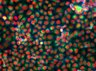
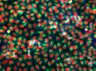
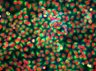
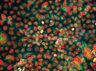
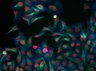
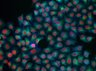
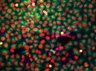
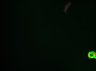
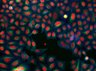
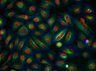
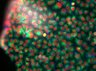
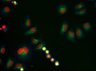
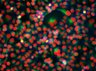
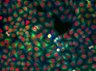
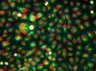
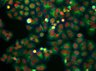
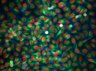
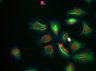
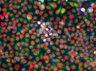
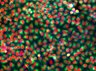
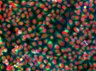
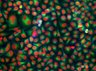
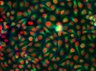
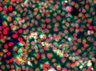
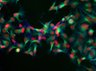
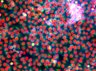
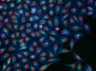
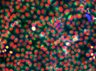
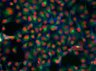
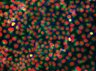
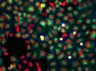
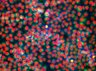
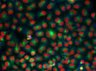
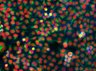
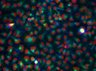
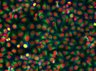
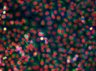
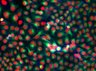
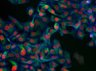
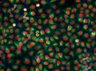
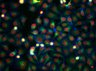
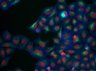
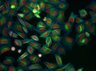
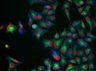
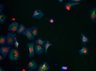
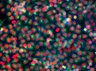
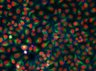
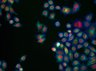
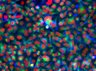
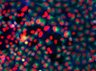
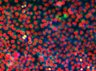
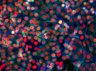
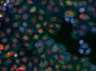
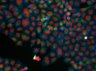
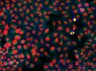
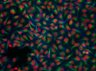
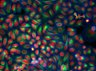
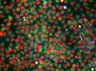
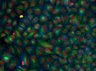
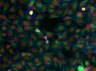
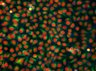
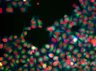
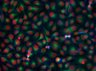
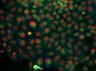
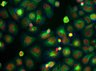
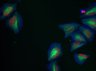
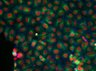
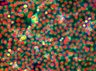
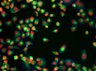
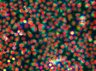
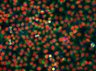
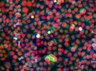
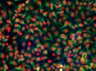
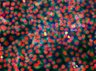
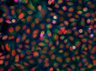
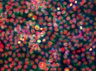
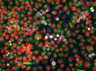
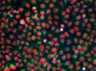
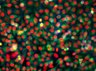
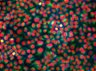
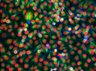
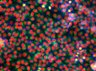
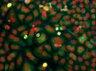
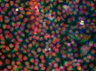
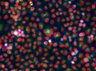
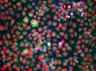
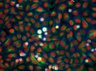
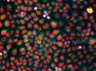
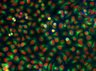
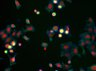
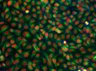
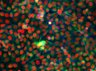
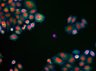
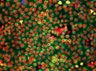
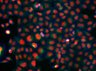
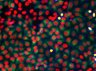
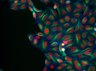
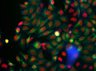
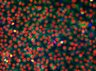
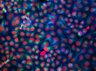
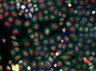
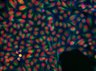
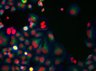
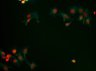
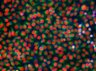
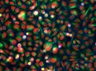
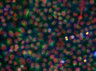
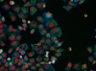
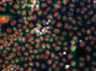
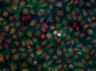
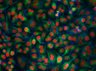
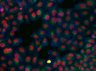
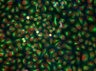
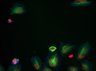
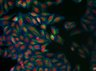
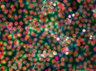
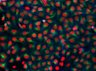
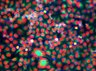
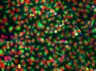
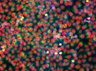
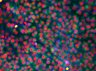
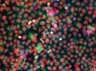
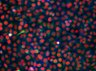
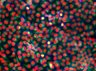
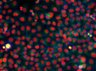
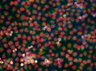
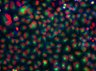
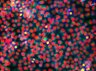
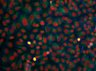
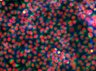
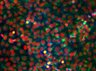
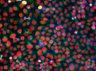
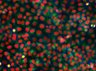
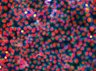
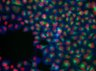
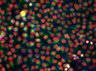
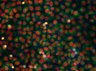
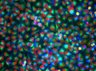
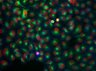
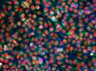
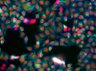
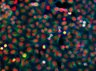
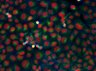
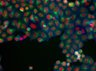
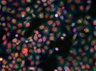
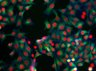
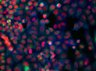
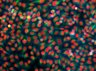
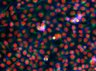
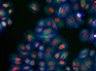
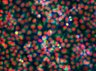
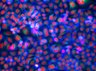
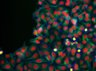
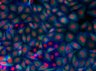
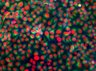
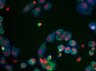
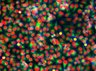
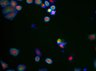
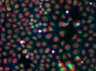
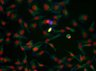
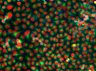
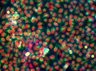
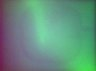
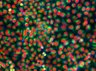
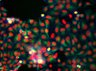
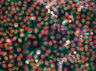
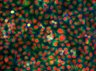
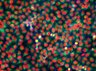
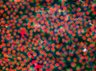
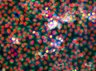
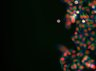
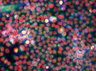
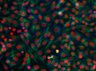
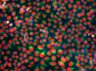
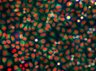
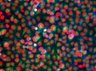
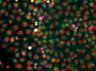
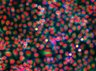
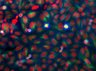
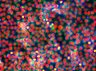
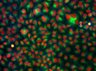
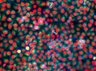
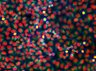
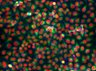
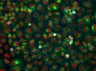
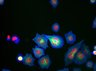
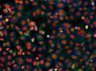
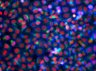
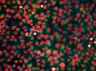
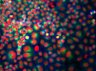
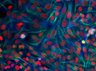
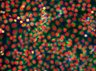
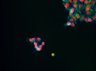
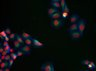
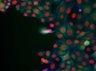
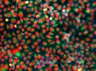
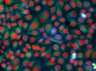
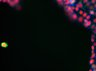
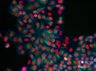
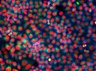
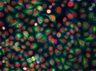
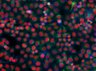
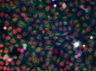
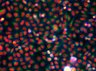
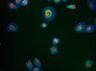
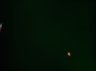
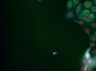
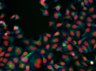
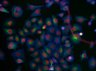
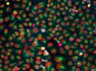
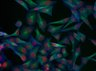
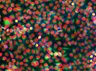
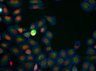
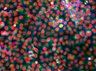
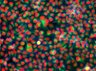
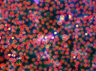
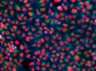
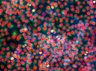
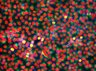
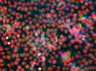
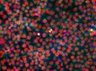
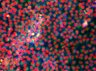
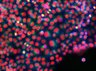
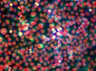
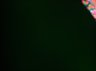
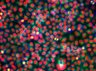
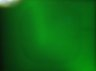
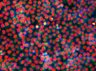
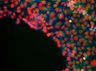
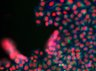
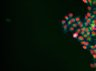
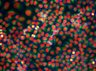
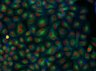
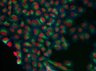
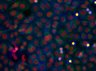
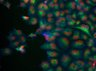
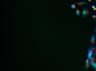
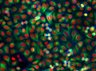
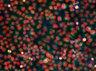
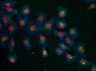
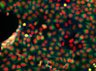
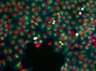
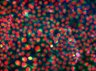
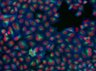
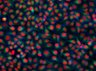
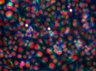
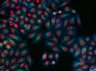
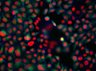
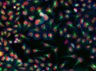
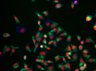
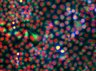
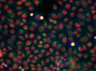
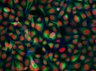
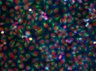
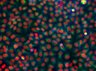
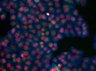
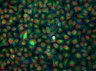
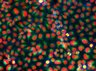
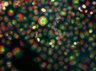
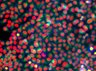
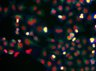
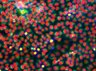
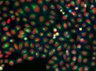
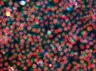
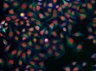
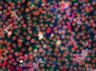
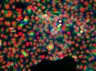
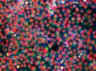
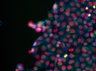
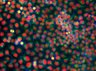
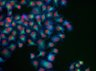
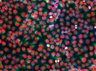
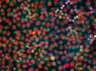
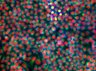
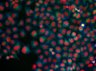
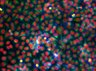
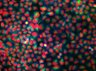
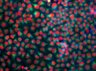
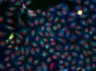
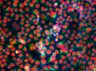
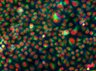
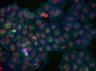
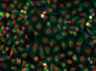
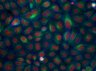
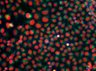
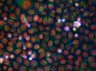
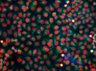
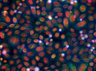
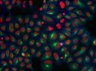
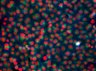
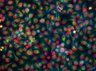
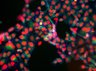
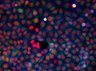
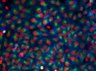
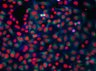
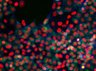
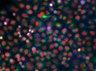
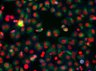
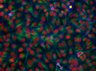
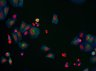
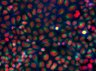
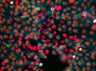
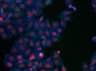
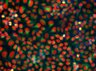
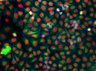
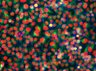
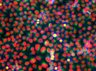
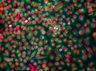
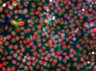
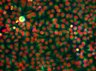
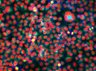
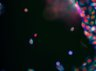
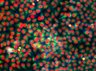
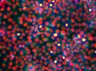
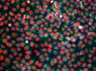
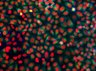
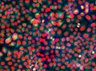
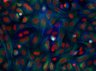
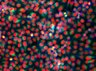
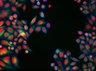
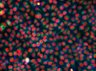
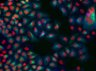
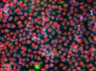
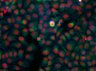
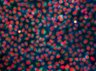
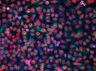
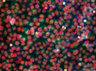
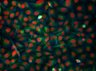
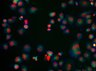
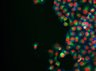
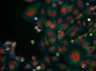
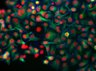
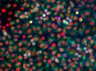
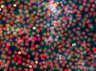
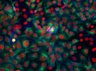
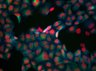
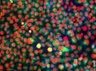
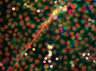
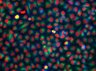
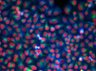
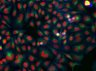
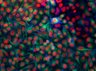
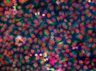
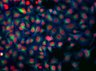
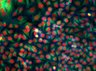
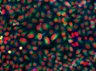
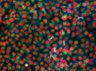
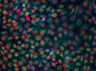
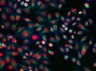
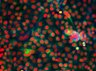
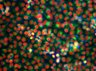
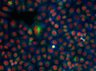
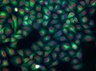
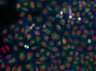
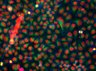
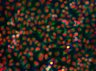
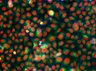
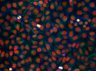
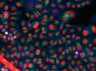
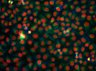
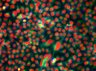
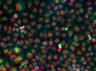
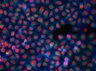
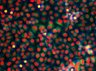
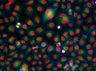
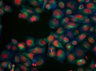
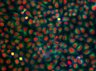
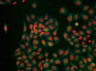
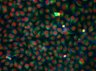
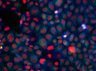
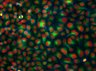
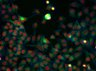
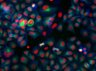
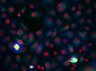
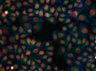
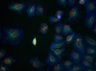

In [6]:
WELLS_IMAGES_URL = "{base}/webgateway/plate/{plate_id}/{field}/"
PLATE_ID = 325

qs = {'base': IDR_BASE_URL, 'plate_id': PLATE_ID, 'field': 0}
url = WELLS_IMAGES_URL.format(**qs)
grid = session.get(url).json()

image_ids = [cell['id'] for row in grid['grid']
             for cell in row if cell is not None]

THUMBNAILS_URL = "{base}/webgateway/get_thumbnails/".format(**{'base': IDR_BASE_URL, })  # noqa


def thumbnails_chunk(image_list, batch):
    for b in range(0, len(image_list), batch):
        yield image_list[b:b + batch]


batch_size = 20

_thumbnails = {}
for batch in thumbnails_chunk(image_ids, batch_size):
    payload = {'id': batch}
    json = session.get(THUMBNAILS_URL, params=payload).json()
    for iid, thumb in json.items():
        _thumbnails[int(iid)] = thumb

# Display plate
_tbody = []
for row in grid['grid']:
    _tr = ["<tr>"]
    for cell in row:
        if cell is not None:
            _tr.append('<td><img src="%s"/></td>' % _thumbnails[cell['id']])
        else:
            _tr.append('<td></td>')
    _tr.append("</tr>")
    _tbody.append("&nbsp;".join(_tr))
display(HTML("<table>" + "".join(_tbody) + "</table>"))

## Get Image:

In [7]:
IMAGE_DETAILS_URL = "{base}/webclient/imgData/{image_id}/"

IMAGE_ID = 122770

qs = {'base': IDR_BASE_URL, 'image_id': IMAGE_ID}
url = IMAGE_DETAILS_URL.format(**qs)
r = session.get(url)
if r.status_code == 200:
    print(r.json())

RENDER_IMAGE = "{base}/webgateway/render_image/{image_id}/0/0/"
img_url = RENDER_IMAGE.format(**qs)

display(HTML("<img src='%s' />" % img_url))

{u'init_zoom': 0, u'tiles': False, u'perms': {u'canAnnotate': False, u'canEdit': False, u'canDelete': False, u'canLink': False}, u'split_channel': {u'c': {u'width': 1398, u'border': 2, u'gridy': 2, u'gridx': 2, u'height': 1046}, u'g': {u'width': 1398, u'border': 2, u'gridy': 2, u'gridx': 2, u'height': 1046}}, u'rdefs': {u'defaultT': 0, u'model': u'color', u'defaultZ': 0, u'invertAxis': False, u'projection': u'normal'}, u'pixel_range': [0, 65535], u'interpolate': True, u'channels': [{u'coefficient': 1.0, u'family': u'linear', u'color': u'FF0000', u'emissionWave': None, u'inverted': False, u'window': {u'max': 4095.0, u'min': 250.0, u'end': 4095.0, u'start': 250.0}, u'active': True, u'label': u'DAPI', u'reverseIntensity': False}, {u'coefficient': 1.0, u'family': u'linear', u'color': u'00FF00', u'emissionWave': None, u'inverted': False, u'window': {u'max': 4095.0, u'min': 694.0, u'end': 4095.0, u'start': 694.0}, u'active': True, u'label': u'FITC-FilterWheel', u'reverseIntensity': False}, {

## Get Image map annotation:

In [8]:
MAP_URL = "{base}/webclient/api/annotations/?type=map&{type}={image_id}"

IMAGE_ID = 122770

qs = {'base': IDR_BASE_URL, 'type': 'image', 'image_id': IMAGE_ID}
url = MAP_URL.format(**qs)
for a in session.get(url).json()['annotations']:
    namespace = a['ns']
    for v in a['values']:
        key = v[0]
        value = v[1]
        print(key, value)

(u'Cell Line', u'HeLa')
(u'Gene Identifier', u'NM_018098')
(u'Gene Identifier URL', u'http://www.ncbi.nlm.nih.gov/nuccore/NM_018098')
(u'Gene Symbol', u'ECT2')
(u'Analysis Gene Annotation Build', u'siRNA Pool Identifiers/Gene symbols from GRCh37, Ensembl release 56, Sept 2009')
(u'Gene Annotation Comments', u'Gene Symbol added using siRNA Pool Identifier name by IDR curator')
(u'Organism', u'Homo sapiens')
(u'Phenotype', u'increased number of zigzag actin stress fibres')
(u'Phenotype Term Name', u'increased amount of zig-zag stress fibers')
(u'Phenotype Term Accession', u'CMPO_0000299')
(u'Phenotype Term Accession URL', u'http://www.ebi.ac.uk/cmpo/CMPO_0000299')
(u'Phenotype', u'loss of cell monolayer')
(u'Phenotype Term Name', u'loss of cell monolayer')
(u'Phenotype Term Accession', u'CMPO_0000293')
(u'Phenotype Term Accession URL', u'http://www.ebi.ac.uk/cmpo/CMPO_0000293')
(u'Phenotype', u'increased DNA area')
(u'Phenotype Term Name', u'increased nucleus size phenotype')
(u'Phenotyp

## Get bulk annotation:

In [9]:
BULK_URL = "{base}/webgateway/table/Screen.plateLinks.child.wells/{well_id}/query/?query=Well-{well_id}"  # noqa

WELL_ID = 45217
qs = {'base': IDR_BASE_URL, 'well_id': WELL_ID}
url = BULK_URL.format(**qs)
r = session.get(url)
print(r.json())


# or download entire bulk_annotation file:

FILEANNOTATION_URL = "{base}/webclient/api/annotations/?type=file&screen={screen_id}"  # noqa
DOWNLOAD_URL = "{base}/webclient/annotation/{ann_id}"

SCREEN_ID = 206

qs = {'base': IDR_BASE_URL, 'screen_id': SCREEN_ID}
url = FILEANNOTATION_URL.format(**qs)
for a in session.get(url).json()['annotations']:
    namespace = a['ns']
    ann_id = a['id']
    qs2 = {'base': IDR_BASE_URL, 'ann_id':  a['id']}
    url2 = DOWNLOAD_URL.format(**qs2)
    print("Download URL:", url2)

{u'parentId': 206, u'addedBy': u'Public data', u'parentType': u'Screen', u'annId': 8368945, u'owner': u'Public data', u'data': {u'rows': [[340, u'338', 45217, u'Plate8_Actinome1_O2', u'Homo sapiens', u'NCBITaxon', u'NCBITaxon_9606', u'HeLa', u'EFO', u'EFO_0001185', u'ECT2-02', u'ECT2', u'D-006450-02', u'GCACUCACCUUGUAGUUGA', u'', u'NM_018098', u'ECT2', u'siRNA Pool Identifiers/Gene symbols from GRCh37, Ensembl release 56, Sept 2009', u'Gene Symbol added using siRNA Pool Identifier name by IDR curator', u'', u'', u'DAPI:DNA;FITC-FilterWheel:alpha-tubulin;TIRTC-FilterWheel:phallodin/F-actin', u'', u'yes', u'yes', u'yes', u'yes', u'gene', u'', u'', u'', u'', u'', u'', u'increased cytoplasmic actin', u'increased actin localised to the cytoplasm', u'CMPO_0000296', u'increased actin over nucleus', u'increased actin localised to the nucleus', u'CMPO_0000294', u'', u'', u'', u'increased width of lamellae', u'increased lamellipodia width phenotype', u'CMPO_0000276', u'', u'', u'', u'', u'', u''

# Attributes (e.g. Gene, Phenotype...)

## Get Screens that are annotated with gene:

In [10]:
SCREENS_PROJECTS_URL = "{base}/mapr/api/{key}/?value={value}"

qs = {'base': IDR_BASE_URL,
      'key': 'gene',
      'value': 'CDC20'}
url = SCREENS_PROJECTS_URL.format(**qs)
for s in session.get(url).json()['screens']:
    screen_id = s['id']
    print(s['id'], s['name'])

(102, u'idr0002-heriche-condensation/screenA (24)')
(51, u'idr0003-breker-plasticity/screenA (15)')
(253, u'idr0006-fong-nuclearbodies/screenA (48)')
(201, u'idr0007-srikumar-sumo/screenA (9)')
(251, u'idr0009-simpson-secretion/screenA (12)')
(1351, u'idr0010-doil-dnadamage/screenA (4)')
(1551, u'idr0011-ledesmafernandez-dad4/screenB (13)')
(1602, u'idr0011-ledesmafernandez-dad4/screenD (21)')
(1202, u'idr0012-fuchs-cellmorph/screenA (2)')
(1101, u'idr0013-neumann-mitocheck/screenA (6)')
(1302, u'idr0013-neumann-mitocheck/screenB (8)')
(1204, u'idr0020-barr-chtog/screenA (120)')


## Get Plates in Screen that are annotated with gene:

In [11]:
PLATES_URL = "{base}/mapr/api/{key}/plates/?value={value}&id={screen_id}"

qs = {'base': IDR_BASE_URL,
      'key': 'gene',
      'value': 'CDC20',
      'screen_id': screen_id}
url = PLATES_URL.format(**qs)
for p in session.get(url).json()['plates']:
    plate_id = p['id']
    print(p['id'], p['name'])

(4357, u'200972429 TOG[2702]')
(4401, u'200972430 TOG[2703]')
(4451, u'200972431 NS[2667]')
(4453, u'200972432 NS[2668]')


## Get Images in Plate that are annotated with gene:

In [12]:
IMAGES_URL = "{base}/mapr/api/{key}/images/?value={value}&node={parent_type}&id={parent_id}"  # noqa

IMAGE_URL = "{base}/webclient/?show=image-{image_id}"
IMAGE_VIEWER = "{base}/webclient/img_detail/{image_id}/"
THUMBNAIL_URL = "{base}/webclient/render_thumbnail/{image_id}/"
ATTRIBUTES_URL = "{base}/webclient/api/annotations/?type=map&image={image_id}"  # noqa

qs = {'base': IDR_BASE_URL,
      'key': 'gene', 'value': 'CDC20',
      'parent_type': 'plate',
      'parent_id': plate_id}
url = IMAGES_URL.format(**qs)
for i in session.get(url).json()['images']:
    image_id = i['id']
    print('Image link:',
          IMAGE_URL.format(**{'base': IDR_BASE_URL, 'image_id': image_id}))
    print('Image viewer link:',
          IMAGE_VIEWER.format(**{'base': IDR_BASE_URL, 'image_id': image_id}))
    print('Thumbnail URL:',
          THUMBNAIL_URL.format(**{'base': IDR_BASE_URL, 'image_id': image_id}))
    url = ATTRIBUTES_URL.format(**{'base': IDR_BASE_URL, 'image_id': image_id})
    print('Annotations:')
    for a in session.get(url).json()['annotations']:
        print('\t%s' % a['values'])

Image link: https://idr.openmicroscopy.org/webclient/?show=image-1915895
Image viewer link: https://idr.openmicroscopy.org/webclient/img_detail/1915895/
Thumbnail URL: https://idr.openmicroscopy.org/webclient/render_thumbnail/1915895/
Annotations:
	[[u'Cell Line', u'HeLa']]
	[[u'Gene Identifier', u'991'], [u'Gene Identifier URL', u'http://www.ncbi.nlm.nih.gov/gene/991'], [u'Gene Symbol', u'CDC20']]
	[[u'RefSeq Accession', u'NM_001255'], [u'RefSeq Accession URL', u'http://www.ncbi.nlm.nih.gov/nuccore/NM_001255'], [u'RefSeq GI Number', u'4557436']]
	[[u'Organism', u'Homo sapiens']]
	[[u'siRNA Pool Identifier', u'L-003225-00'], [u'siRNA Identifier', u'']]
	[[u'siRNA Sequences', u'CGGAAGACCUGCCGUUACA;GGGCCGAACUCCUGGCAAA;GAUCAAAGAGGGCAACUAC;CAGAACAGACUGAAAGUAC']]
	[[u'shRNA', u'non-silencing shRNA'], [u'Channels', u'Hoescht: nuclei;Anti-Ser10 PhosphoHistone H3: mitotic nuclei;Anti-alpha-tubulin: microtubules;RFP: whole cell']]
Image link: https://idr.openmicroscopy.org/webclient/?show=image

### License (BSD 2-Clause)¶

Copyright (C) 2016-2021 University of Dundee. All Rights Reserved.

Redistribution and use in source and binary forms, with or without modification, are permitted provided that the following conditions are met:

Redistributions of source code must retain the above copyright notice, this list of conditions and the following disclaimer. Redistributions in binary form must reproduce the above copyright notice, this list of conditions and the following disclaimer in the documentation and/or other materials provided with the distribution. THIS SOFTWARE IS PROVIDED BY THE COPYRIGHT HOLDERS AND CONTRIBUTORS "AS IS" AND ANY EXPRESS OR IMPLIED WARRANTIES, INCLUDING, BUT NOT LIMITED TO, THE IMPLIED WARRANTIES OF MERCHANTABILITY AND FITNESS FOR A PARTICULAR PURPOSE ARE DISCLAIMED. IN NO EVENT SHALL THE COPYRIGHT OWNER OR CONTRIBUTORS BE LIABLE FOR ANY DIRECT, INDIRECT, INCIDENTAL, SPECIAL, EXEMPLARY, OR CONSEQUENTIAL DAMAGES (INCLUDING, BUT NOT LIMITED TO, PROCUREMENT OF SUBSTITUTE GOODS OR SERVICES; LOSS OF USE, DATA, OR PROFITS; OR BUSINESS INTERRUPTION) HOWEVER CAUSED AND ON ANY THEORY OF LIABILITY, WHETHER IN CONTRACT, STRICT LIABILITY, OR TORT (INCLUDING NEGLIGENCE OR OTHERWISE) ARISING IN ANY WAY OUT OF THE USE OF THIS SOFTWARE, EVEN IF ADVISED OF THE POSSIBILITY OF SUCH DAMAGE.